Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
# path for desktop PC
sys.path.append(r'C:\Users\test\Masterarbeit')
# path for surface PC
#sys.path.append(r'C:\Users\Surface\Masterarbeit')

%matplotlib inline
# path for desktop PC
path = r"C:\Users\test\Masterarbeit\data\WZ_2_Feature_Engineered_Fynn6.xlsx"
# path for surface PC
#path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"

df = pd.read_excel(path)


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import r2_score

Transformation Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import prep
import importlib
importlib.reload(prep)

# set the target variable
target = 'C1_V01_delta_kan'
#print(df.columns)
# get the numerical features
data_num = df.drop(['C1_V01_delta_kan'], axis = 1, inplace=False)
#print(data_num.columns)
# get the target values
data_labels = df[target].to_numpy()

# split the data into training, validation and test sets
# 60% training, 20%, validation, 20% test
X_temp, X_test_prep, y_temp, y_test = train_test_split(data_num, data_labels, test_size= 0.2, random_state=42)
X_train_prep, X_val_prep, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

# use coustom function "cat_transform" from prep.py to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = prep.cat_transform(X_train_prep, X_val_prep, X_test_prep, ['BT_NR', 'STP_NR'])
print(X_train_prep.columns)

# pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# get the feature names after preprocessing for the feature importance
feature_names = X_train_prep.columns

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train_prep)
X_val = data_pipeline.transform(X_val_prep)
X_test = data_pipeline.transform(X_test_prep)

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# print the shapes of the data
print(data_num.shape, X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
# print(pd.DataFrame(X_train, columns=feature_names).describe())

Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
(52011, 37) torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])


Class for flexibel NN with Dropout

In [ ]:
# create a class for Neural Network with a custom architecture
class Cusom_NN_Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, do_rate):
        """
        Neural Network model with a custom architecture.
        @param input_dim:   number of input features
        @param hidden_dims: list of integers representing the number of neurons in each hidden layer e.g. [64, 128, 64, 32]
        @param output_dim:  number of output features (usually 1 for regression tasks)
        @param do_rate:     dropout rate for regularization
               
        """
        super(Cusom_NN_Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.do_rate = do_rate
        
        # create the layers of the model
        self.layers = torch.nn.ModuleList()
        last_dim = input_dim
        for dim in hidden_dims:
            self.layers.append(torch.nn.Linear(last_dim, dim))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Dropout(do_rate))
            last_dim = dim
        
        # output layer
        self.layers.append(torch.nn.Linear(last_dim, output_dim))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


Training function for NN including data loader with batch sampling, early stopping

In [31]:
# training functions for the model, optimizer Adam, loss function MSELoss, data loader for batching the data, early stopping
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=128, n_epochs=1000, lr=0.01, weight_decay=0.0001, patience=20):
        
    """
        Function for training neural Network.
        @param model            The neural network model to be trained.
        @param X_train_tensor   The matrix of features for the training data.
        @param y_train_tensor   The vector of target values for the training data.
        @param X_val_tensor     The matrix of features for the validation data.
        @param y_val_tensor     The vector of target values for the validation data.
        @param batch_size       The size of the batches for training.
        @param n_epochs         The number of epochs for training.
        @param lr               The learning rate for the optimizer.
        @param weight_decay     The weight decay for the optimizer.
        @param patience         The number of epochs with no improvement after which training will be stopped.
                
        @return model          The trained neural network model.
    """
    
    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Define Mean Squared Error loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')
    
    # Adam optimizer with weight decay for regularization
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)  

    # Early Stopping values
    best_val_loss = np.inf
    epochs_no_improve = 0
    loss_history = []
    val_loss_history = []

    for epoch in range(n_epochs):
        model.train()                           # Set model to training mode
        batch_losses = []
        for X_batch, y_batch in train_loader:   # loop over all batches in the DataLoader
            optimizer.zero_grad()               # Reset gradients
            y_pred = model(X_batch)             # Forward pass
            loss = loss_fn(y_pred, y_batch)     # Compute MSE loss
            loss.backward()                     # Backpropagation
            optimizer.step()                    # Update weights
            batch_losses.append(loss.item())   
        loss_history.append(loss.item())    # Save loss value

        # calculate validation loss
        model.eval()                            # Set model to evaluation mode
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)           # Forward pass on validation set
            val_loss = loss_fn(y_val_pred, y_val_tensor)  # Compute MSE loss on validation set
            val_loss_history.append(val_loss.item())
            
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            #print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(batch_losses):.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}")
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                model.load_state_dict(best_model_state)
                break     
           
    # plt.figure(figsize=(8, 4))
    # plt.plot(loss_history, label='Train Loss', color='tab:blue')
    # plt.xlabel('Epoch')
    # plt.ylabel('MSE Loss')
    # plt.title('Training Loss over Epochs')
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    
    return model


Optuna from Chat GPT

In [27]:
import optuna

def objective(trial):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # Hyperparameter-Sampling durch Optuna
    hidden_dims = trial.suggest_categorical("hidden_dims", [[128, 64], [256, 128, 64], [512, 256, 128, 64]])
    do_rate = trial.suggest_float("do_rate", 0.05, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # Modell initialisieren
    model = Cusom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=do_rate
    ).to(device)


    # Nutze deine bestehende train_model Funktion
    trained_model = train_model(
        model,
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        batch_size=batch_size,
        n_epochs=500,
        lr=lr,
        weight_decay=weight_decay,
        patience=15
    )

    # Validation Loss berechnen
    loss_fn = torch.nn.MSELoss(reduction='mean')
    trained_model.eval()
    with torch.no_grad():
        y_val_pred = trained_model(X_val_tensor)
        val_loss = loss_fn(y_val_pred, y_val_tensor).item()

    # Logging
    trial.set_user_attr("val_loss", val_loss)

    return val_loss


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)


study.optimize(objective, n_trials=50, timeout=None)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Validation Loss: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-27 17:59:54,996] A new study created in memory with name: no-name-7808d2f3-8cdc-47f1-bb1b-a7faa1adb73c


Using device: cuda
Using device: cuda


[I 2025-06-27 18:01:14,269] Trial 0 finished with value: 16.845787048339844 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.1831111289677293, 'lr': 0.0002135205059044546, 'weight_decay': 0.0010741676126172618, 'batch_size': 128}. Best is trial 0 with value: 16.845787048339844.


Using device: cuda


[I 2025-06-27 18:03:50,711] Trial 1 finished with value: 12.684627532958984 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.05897440472408446, 'lr': 0.00014264012700946274, 'weight_decay': 0.0007203088925123536, 'batch_size': 256}. Best is trial 1 with value: 12.684627532958984.


Using device: cuda


[I 2025-06-27 18:05:24,224] Trial 2 finished with value: 12.998421669006348 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.08191646418079743, 'lr': 0.00045375802843368874, 'weight_decay': 0.0031175682708009193, 'batch_size': 256}. Best is trial 1 with value: 12.684627532958984.


Using device: cuda


[I 2025-06-27 18:08:29,984] Trial 3 finished with value: 12.45888900756836 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.3073665574113445, 'lr': 0.0015765227446530297, 'weight_decay': 1.6112723291645054e-05, 'batch_size': 64}. Best is trial 3 with value: 12.45888900756836.


Using device: cuda


[I 2025-06-27 18:09:02,214] Trial 4 finished with value: 18.99349021911621 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.3103460354759667, 'lr': 0.0022690845200919, 'weight_decay': 0.001067854863148639, 'batch_size': 256}. Best is trial 3 with value: 12.45888900756836.


Using device: cuda


[I 2025-06-27 18:13:06,726] Trial 5 finished with value: 11.030177116394043 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.05711321441721788, 'lr': 0.00011729631784418703, 'weight_decay': 0.004490688804041443, 'batch_size': 128}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:15:18,094] Trial 6 finished with value: 17.03032684326172 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.2609458291645164, 'lr': 0.0002720103205298833, 'weight_decay': 1.35660988476574e-06, 'batch_size': 64}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:15:54,056] Trial 7 finished with value: 39.291282653808594 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.35314057502372986, 'lr': 0.0009065462440848292, 'weight_decay': 2.2082291111544934e-05, 'batch_size': 64}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:17:37,420] Trial 8 finished with value: 16.135650634765625 and parameters: {'hidden_dims': [512, 256, 128, 64], 'do_rate': 0.3097823251641386, 'lr': 0.0002628111951066451, 'weight_decay': 1.0234775825973065e-06, 'batch_size': 128}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:18:54,086] Trial 9 finished with value: 11.858073234558105 and parameters: {'hidden_dims': [512, 256, 128, 64], 'do_rate': 0.05561490670785945, 'lr': 0.00032550631281705127, 'weight_decay': 1.0805210425490726e-05, 'batch_size': 256}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:20:14,917] Trial 10 finished with value: 14.125669479370117 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.15453661307211575, 'lr': 0.00918700758324938, 'weight_decay': 0.009437581910081318, 'batch_size': 128}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:22:51,564] Trial 11 finished with value: 14.124908447265625 and parameters: {'hidden_dims': [512, 256, 128, 64], 'do_rate': 0.111027139820041, 'lr': 0.00011049357132852815, 'weight_decay': 5.741241073051063e-05, 'batch_size': 128}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:23:59,613] Trial 12 finished with value: 13.997383117675781 and parameters: {'hidden_dims': [512, 256, 128, 64], 'do_rate': 0.1354772700256715, 'lr': 0.0005786828639156927, 'weight_decay': 5.71436182690301e-06, 'batch_size': 256}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:25:25,354] Trial 13 finished with value: 15.620595932006836 and parameters: {'hidden_dims': [512, 256, 128, 64], 'do_rate': 0.20247403266732278, 'lr': 0.00011318302878761908, 'weight_decay': 0.0002095468079820372, 'batch_size': 256}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:27:27,308] Trial 14 finished with value: 11.988789558410645 and parameters: {'hidden_dims': [512, 256, 128, 64], 'do_rate': 0.0571687439381087, 'lr': 0.0005181932413853813, 'weight_decay': 0.0001621600968615877, 'batch_size': 128}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:29:55,259] Trial 15 finished with value: 12.658241271972656 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.10136445065529523, 'lr': 0.00021264126357626266, 'weight_decay': 1.0997123758249805e-05, 'batch_size': 128}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:31:48,251] Trial 16 finished with value: 11.38882827758789 and parameters: {'hidden_dims': [512, 256, 128, 64], 'do_rate': 0.24943438373672688, 'lr': 0.004078566161593086, 'weight_decay': 4.3739651001348846e-05, 'batch_size': 256}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:32:36,152] Trial 17 finished with value: 14.201184272766113 and parameters: {'hidden_dims': [512, 256, 128, 64], 'do_rate': 0.2529875301760231, 'lr': 0.005399183056502863, 'weight_decay': 5.085496969605082e-05, 'batch_size': 256}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:35:05,116] Trial 18 finished with value: 12.16939926147461 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.3870673941483238, 'lr': 0.002281879254609147, 'weight_decay': 0.0003859982533421909, 'batch_size': 128}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:38:35,361] Trial 19 finished with value: 11.388686180114746 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.24633896017989237, 'lr': 0.0047162386035835046, 'weight_decay': 0.0043072231943934395, 'batch_size': 64}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:39:58,946] Trial 20 finished with value: 15.875961303710938 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.21527169390234713, 'lr': 0.009114719620821166, 'weight_decay': 0.009713411835127306, 'batch_size': 64}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:41:30,805] Trial 21 finished with value: 13.465556144714355 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.25808411143095916, 'lr': 0.004376084940154116, 'weight_decay': 0.0021040904900155918, 'batch_size': 64}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:44:28,613] Trial 22 finished with value: 11.543445587158203 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.175431380931591, 'lr': 0.004431063024547697, 'weight_decay': 0.0037495522571913335, 'batch_size': 64}. Best is trial 5 with value: 11.030177116394043.


Using device: cuda


[I 2025-06-27 18:47:30,600] Trial 23 finished with value: 10.863190650939941 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.2768354324242909, 'lr': 0.00296444531867338, 'weight_decay': 0.0003730517779641064, 'batch_size': 64}. Best is trial 23 with value: 10.863190650939941.


Using device: cuda


[I 2025-06-27 19:26:34,802] Trial 24 finished with value: 12.927746772766113 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.35289913490118674, 'lr': 0.002538927641601263, 'weight_decay': 0.004023227558119393, 'batch_size': 64}. Best is trial 23 with value: 10.863190650939941.


Using device: cuda


[I 2025-06-27 19:27:34,172] Trial 25 finished with value: 18.478599548339844 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.28397837135091225, 'lr': 0.0011470200427782268, 'weight_decay': 0.0004276150826374939, 'batch_size': 64}. Best is trial 23 with value: 10.863190650939941.


Using device: cuda


[I 2025-06-27 19:31:15,690] Trial 26 finished with value: 10.963407516479492 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.23342445690349745, 'lr': 0.0062623422139359486, 'weight_decay': 0.0017805697379497697, 'batch_size': 64}. Best is trial 23 with value: 10.863190650939941.


Using device: cuda


[I 2025-06-27 19:34:00,754] Trial 27 finished with value: 11.315781593322754 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.22215179622925701, 'lr': 0.006171936927747772, 'weight_decay': 0.001957072822997579, 'batch_size': 64}. Best is trial 23 with value: 10.863190650939941.


Using device: cuda


[I 2025-06-27 19:38:00,682] Trial 28 finished with value: 10.611042976379395 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.28073804942745834, 'lr': 0.0029264351441037903, 'weight_decay': 0.0004509013897323928, 'batch_size': 64}. Best is trial 28 with value: 10.611042976379395.


Using device: cuda


[I 2025-06-27 19:42:40,013] Trial 29 finished with value: 9.759156227111816 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.28050090902332037, 'lr': 0.0034994038932607326, 'weight_decay': 0.0005007498326251006, 'batch_size': 64}. Best is trial 29 with value: 9.759156227111816.


Using device: cuda


[I 2025-06-27 19:47:51,336] Trial 30 finished with value: 9.742810249328613 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.279588129653978, 'lr': 0.0033656652625489833, 'weight_decay': 0.00016148769820359345, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 19:52:41,880] Trial 31 finished with value: 9.989750862121582 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.2868430323966933, 'lr': 0.0027225905825053035, 'weight_decay': 0.0001323273317720494, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 19:55:55,131] Trial 32 finished with value: 12.513575553894043 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.34070484919576666, 'lr': 0.0017282474645257816, 'weight_decay': 0.00010970645669257682, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:00:06,537] Trial 33 finished with value: 9.897445678710938 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.28824585257114765, 'lr': 0.003520304816581267, 'weight_decay': 0.0006279690541492509, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:04:31,850] Trial 34 finished with value: 11.467068672180176 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.32757146861211706, 'lr': 0.0014098722541652025, 'weight_decay': 0.0007207212530403688, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:08:48,545] Trial 35 finished with value: 9.794684410095215 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.2806945571534223, 'lr': 0.0033610803847625055, 'weight_decay': 0.00017132173041103845, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:12:43,356] Trial 36 finished with value: 10.38328742980957 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.3025159398290785, 'lr': 0.003641297286442385, 'weight_decay': 0.0002672466472205185, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:14:48,837] Trial 37 finished with value: 12.172648429870605 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.37574591013077996, 'lr': 0.007111808996648766, 'weight_decay': 0.000789748221659546, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:18:03,669] Trial 38 finished with value: 12.413838386535645 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.3266696944069882, 'lr': 0.0017822181757956956, 'weight_decay': 7.840520763208388e-05, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:18:42,149] Trial 39 finished with value: 27.397571563720703 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.19667836238038128, 'lr': 0.0035036363520797175, 'weight_decay': 0.0009726148920511802, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:21:47,979] Trial 40 finished with value: 14.307771682739258 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.29732402372962236, 'lr': 0.0009034084102335585, 'weight_decay': 0.0002320359197846994, 'batch_size': 64}. Best is trial 30 with value: 9.742810249328613.


Using device: cuda


[I 2025-06-27 20:27:58,207] Trial 41 finished with value: 9.478965759277344 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.26902358140422183, 'lr': 0.0021307905209376476, 'weight_decay': 0.00010854257831210668, 'batch_size': 64}. Best is trial 41 with value: 9.478965759277344.


Using device: cuda


[I 2025-06-27 20:30:06,338] Trial 42 finished with value: 12.905811309814453 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.26812672249312164, 'lr': 0.0021776248547493147, 'weight_decay': 3.524642643671684e-05, 'batch_size': 64}. Best is trial 41 with value: 9.478965759277344.


Using device: cuda


[I 2025-06-27 20:30:43,784] Trial 43 finished with value: 23.044111251831055 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.3237755377374501, 'lr': 0.003335630185677838, 'weight_decay': 7.4353930967373e-05, 'batch_size': 64}. Best is trial 41 with value: 9.478965759277344.


Using device: cuda


[I 2025-06-27 20:33:38,881] Trial 44 finished with value: 11.566282272338867 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.23858198601855915, 'lr': 0.0019875625267828313, 'weight_decay': 2.749404254485009e-05, 'batch_size': 64}. Best is trial 41 with value: 9.478965759277344.


Using device: cuda


[I 2025-06-27 20:36:13,694] Trial 45 finished with value: 13.270506858825684 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.2629443233958279, 'lr': 0.0013812891160633566, 'weight_decay': 0.00014077880144094948, 'batch_size': 64}. Best is trial 41 with value: 9.478965759277344.


Using device: cuda


[I 2025-06-27 20:40:38,839] Trial 46 finished with value: 10.413114547729492 and parameters: {'hidden_dims': [256, 128, 64], 'do_rate': 0.29354971714163575, 'lr': 0.0007316429617489819, 'weight_decay': 0.001313793495115071, 'batch_size': 64}. Best is trial 41 with value: 9.478965759277344.


Using device: cuda


[I 2025-06-27 20:42:58,286] Trial 47 finished with value: 11.220572471618652 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.3057504053873256, 'lr': 0.00767096364165899, 'weight_decay': 0.0005583493069173843, 'batch_size': 64}. Best is trial 41 with value: 9.478965759277344.


Using device: cuda


[I 2025-06-27 20:46:02,382] Trial 48 finished with value: 10.891596794128418 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.2700774848770645, 'lr': 0.005491935422437661, 'weight_decay': 0.00027214128383092854, 'batch_size': 64}. Best is trial 41 with value: 9.478965759277344.


Using device: cuda


[I 2025-06-27 20:46:24,451] Trial 49 finished with value: 20.963584899902344 and parameters: {'hidden_dims': [128, 64], 'do_rate': 0.3226593564734739, 'lr': 0.003376727921787697, 'weight_decay': 0.00017127349114822276, 'batch_size': 256}. Best is trial 41 with value: 9.478965759277344.


Number of finished trials:  50
Best trial:
  Validation Loss: 9.4790
  Params:
    hidden_dims: [128, 64]
    do_rate: 0.26902358140422183
    lr: 0.0021307905209376476
    weight_decay: 0.00010854257831210668
    batch_size: 64


In [31]:
best_params = trial.params

best_model = Cusom_NN_Model(
    input_dim=X_train_tensor.shape[1],
    hidden_dims=best_params['hidden_dims'],
    output_dim=1,
    do_rate=best_params['do_rate']
).to(device)

trained_model = train_model(
    best_model,
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    batch_size=best_params['batch_size'],
    n_epochs=500,        # ggf. höher setzen
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay'],
    patience=20          # etwas höher für finale Trainingsläufe
)


KeyboardInterrupt: 

Training NN with MC Dropout with best params

In [37]:
model1 = Cusom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[128, 64], output_dim=1, do_rate=0.27).to(device)  # Create model instance and move to device

tr_model = train_model(model1, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=64, n_epochs=1000, lr=0.002, weight_decay=0.0001, patience=20)

Early stopping at epoch 369, Best Val Loss: 8.9998


Inference on the Train and test data without aleatoric uncertainty

In [38]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model.train()
tr_model.to('cpu')  # Ensure the model is on the correct device
X_tr = X_train_tensor.to('cpu')  # Ensure the input data is on the correct device
X_te = X_test_tensor.to('cpu')  # Ensure the test data is on the correct device
# Number of stochastic forward passes for MC Dropout
n_samples = 250

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred = torch.stack([tr_model(X_tr) for i in range(n_samples)]).detach().cpu().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred = torch.stack([tr_model(X_te) for i in range(n_samples)]).detach().cpu().numpy()

Calculate tau for aleatoric uncertainty

In [74]:
l= 4  # length scale for uncertainty estimation
N= len(X_train_tensor)  # Number of training samples
print(N)
tau = (1- dp)*l**2 / (2*weight_decay*N)  # Calculate tau for uncertainty estimation
print(f"tau: {tau:.4f}")

31206
tau: 0.1871


Plot the uncertainty interval for the NN with MC Dropout

R² on Train Data: 0.860
R² on Test Data: 0.842
Negative Log Likelihood (NLL) on Test Data: -2.514
Coverage: 95.00%


C:\Users\test\AppData\Local\Temp\ipykernel_17268\1872320714.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ll = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_test_pred)**2,dim = 0) -np.log(n_samples) - 0.5 * np.log(2*np.pi) + 0.5 * np.log(tau))


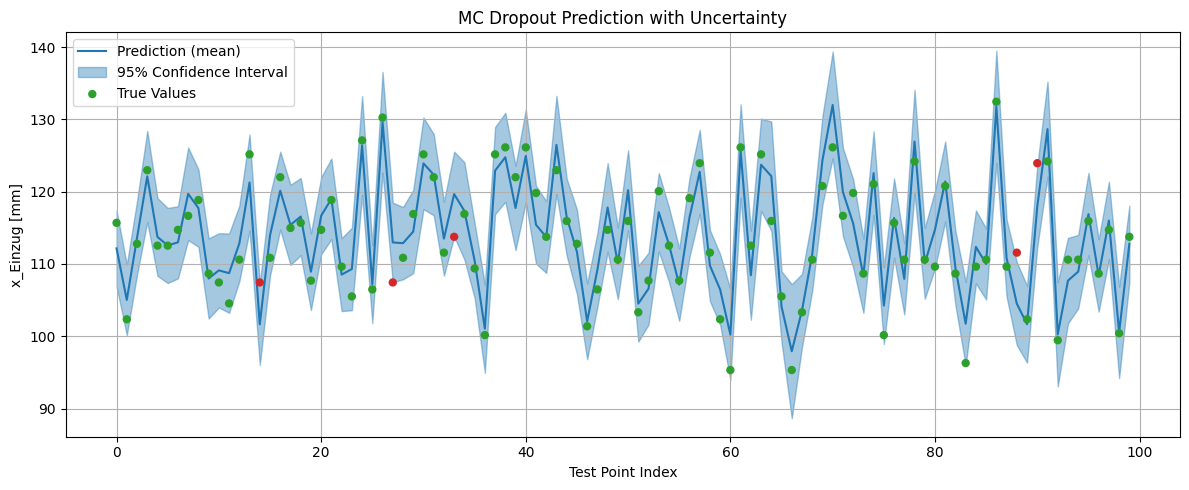

In [75]:
#! handling the train data
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred.mean(axis = 0)
y_train_Pred_std = y_train_pred.std(axis = 0)

# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred.mean(axis = 0)
y_test_pred_std = y_test_pred.std(axis = 0)
# Adjust standard deviation for uncertainty estimation
y_test_pred_var = y_test_pred_std**2 + (1/tau)
y_test_pred_std = np.sqrt(y_test_pred_var)


# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# calculate NLL for the test data
ll = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_test_pred)**2,dim = 0) -np.log(n_samples) - 0.5 * np.log(2*np.pi) + 0.5 * np.log(tau))
test_ll = ll.mean()  # Mean Negative Log Likelihood
test_ll = test_ll.to('cpu')  # Move to CPU for printing
nll = -test_ll
print(f"Negative Log Likelihood (NLL) on Test Data: {test_ll:.3f}")


# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean[random_indices] - 2 * mc_std[random_indices]
mc_upper_bound = mc_mean[random_indices] + 2 * mc_std[random_indices]

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test[random_indices] >= mc_lower_bound) & (y_test[random_indices] <= mc_upper_bound)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound, mc_upper_bound, alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()